In [14]:
import torch
import w1d4_tests
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_train, data_test = w1d4_tests.load_image("pic.jpg")

In [7]:
class MyModule(torch.nn.Module):
    def __init__(self, P, H, K) -> None:
        super().__init__()
        self.P = P
        self.H = H
        self.K = K
    
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(P, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, K),
        )
    
    def forward(self, x):
        return self.layers(x)

In [8]:
w1d4_tests.test_mlp(MyModule)

Congrats! You've passed the test.


In [9]:
def train(model, dataloader, lr, momentum):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = torch.nn.L1Loss()
    for input, target in dataloader:
        optimizer.zero_grad()
        preds = model(input)
        loss = loss_fn(preds, target)
        loss.backward()
        optimizer.step()
    return model

In [10]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [11]:
def evaluate(model, dataloader):
    loss_fn = torch.nn.L1Loss()
    loss = 0
    for input, target in dataloader:
        pred = model(input)
        loss += loss_fn(pred, target)
    return loss/len(dataloader)

In [12]:
w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [26]:
model = MyModule(2, 400, 3)
train_loss = []
test_loss = []
for i in range(10):
    train(model, data_train, lr=0.01, momentum=0.9)
    train_loss.append(evaluate(model, data_train).item())
    test_loss.append(evaluate(model, data_test).item())


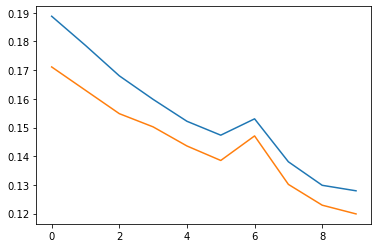

In [32]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()


In [36]:
model.eval()
res = torch.zeros(500, 500, 3)
for i in range(500.):
    for j in range(500.):
        out = model(torch.tensor([i,j]))
        res[i][j] = out
plt.imshow(res.numpy())

TypeError: 'float' object cannot be interpreted as an integer